In [1]:
import gpxpy
import matplotlib.pyplot as plt
import datetime
from geopy import distance, units
from math import sqrt, floor
import numpy as np
import pandas as pd
from haversine import haversine, Unit

In [38]:
#TODO: Check Stopping and starting

gpx_file = open('data/Garmin GPX Example.gpx', 'r')
# gpx_file = open('data/Alex Marathon.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

data = []

for track in gpx.tracks: #typically 1
    for segment in track.segments: #typically 1
        data += segment.points #every second is another point


In [39]:
def single_ext_check(ext,index,hr = np.nan, cad = np.nan):
    try: 
        if ext[index].tag.split('}')[-1] == 'hr':
            hr = ext[index]
        elif ext[index].tag.split('}')[-1] == 'cad':
            cad = ext[index]
    except IndexError:
        print('Extension Error at Index: ', index)
        pass


    return hr, cad

In [40]:
def extension_error_check(point):
    try:
        ext = point.extensions[0]
    except IndexError:
        print('No Extensions')
        pass
    hr, cad = single_ext_check(ext,0)
    hr, cad = single_ext_check(ext,1, hr, cad)

    return hr, cad

In [41]:
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time', 'hr', 'cad'])
for point in data:
    # print(point.extensions[0].text)
    hr, cad = extension_error_check(point)
    row = {
        'lon': point.longitude, 
        'lat' : point.latitude,
        'alt' : point.elevation,
        'time' : point.time,
        'hr': hr.text,
        'cad': cad.text
    }
    df = df.append(row, ignore_index=True)
df_copy = df.copy()

In [42]:
df = df_copy.copy()

In [43]:
df['hr'] = df['hr'].astype(int)
df['cad'] = df['cad'].astype(int)

In [44]:
 df[df.cad!=0].mean(numeric_only=True), df.mean(numeric_only=True)

(lon    -73.974218
 lat     40.703221
 alt      5.763530
 hr     159.249245
 cad     81.002590
 dtype: float64,
 lon    -73.974487
 lat     40.703243
 alt      5.758069
 hr     158.830059
 cad     78.462793
 dtype: float64)

In [45]:
df['time'] = df.time.dt.tz_localize(None)

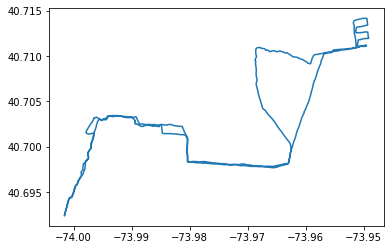

In [46]:
plt.plot(df['lon'], df['lat'])


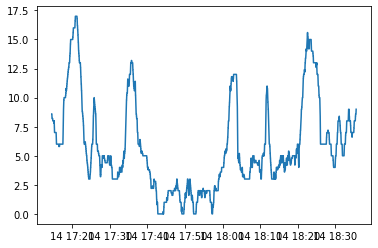

In [47]:
plt.plot(df['time'], df['alt'])

In [48]:
df.iloc[-1].time-df.iloc[0].time

Timedelta('0 days 01:20:52')

In [49]:
# df['lon'] = df['lon'].round(6)
# df['lat'] = df['lat'].round(6)

In [50]:
df['next_lon'] = df ['lon'].shift(-1)
df['next_lat'] = df ['lat'].shift(-1)

In [51]:
df.hr.max()

177

In [52]:
df['haversine_2d_meters'] = df.apply(lambda x: 1000*haversine((x['lat'], x['lon']),(x['next_lat'], x['next_lon'])),axis=1)

In [53]:
df['havec_distance_2d'] = df['haversine_2d_meters'].cumsum()

In [54]:
df['havec_distance_2d_miles'] = df['havec_distance_2d']/1000*units.miles(kilometers=1)

In [55]:
df

,lon,lat,alt,time,hr,cad,next_lon,next_lat,haversine_2d_meters,havec_distance_2d,havec_distance_2d_miles
0,-73.949542,40.711207,8.6,2021-03-14 17:14:38,92,0,-73.949568,40.711211,2.251026,2.251026,0.001399
1,-73.949568,40.711211,8.6,2021-03-14 17:14:39,91,0,-73.949589,40.711207,1.795273,4.046299,0.002514
2,-73.949589,40.711207,8.4,2021-03-14 17:14:40,91,0,-73.949622,40.711201,2.815579,6.861879,0.004264
3,-73.949622,40.711201,8.4,2021-03-14 17:14:41,90,0,-73.949660,40.711193,3.306974,10.168852,0.006319
4,-73.949660,40.711193,8.2,2021-03-14 17:14:42,90,0,-73.949695,40.711185,3.101897,13.270750,0.008246
...,...,...,...,...,...,...,...,...,...,...,...
4779,-73.949764,40.711062,8.6,2021-03-14 18:35:26,164,79,-73.949652,40.711080,9.673606,16353.391190,10.161526
4780,-73.949652,40.711080,8.6,2021-03-14 18:35:27,164,79,-73.949615,40.711085,3.175738,16356.566928,10.163499
4781,-73.949615,40.711085,8.8,2021-03-14 18:35:28,164,79,-73.949577,40.711088,3.165893,16359.732820,10.165467
4782,-73.949577,40.711088,9.0,2021-03-14 18:35:29,163,79,-73.949510,40.711097,5.731875,16365.464695,10.169028


In [123]:
alt_dif = [0]
time_dif = [0]
dist_vin = [0]
dist_hav = [0]
dist_vin_no_alt = [0]
dist_hav_no_alt = [0]
dist_dif_hav_2d = [0]
dist_dif_vin_2d = [0]
for index in range(len(data)):
    if index == 0:
        pass
    else:
        start = data[index-1]
        
        stop = data[index]
        
        distance_vin_2d = \
            distance.geodesic((start.latitude, start.longitude), (stop.latitude, stop.longitude)).m
        dist_dif_vin_2d.append(distance_vin_2d)
        
        distance_hav_2d = haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000
        dist_dif_hav_2d.append(distance_hav_2d)
        
        dist_vin_no_alt.append(dist_vin_no_alt[-1] + distance_vin_2d)
        
        dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)
        
        alt_d = start.elevation - stop.elevation
        
        alt_dif.append(alt_d)
        
        distance_vin_3d = sqrt(distance_vin_2d**2 + (alt_d)**2)
        
        distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2)
                
        time_delta = (stop.time - start.time).total_seconds()
        
        time_dif.append(time_delta)
                
        dist_vin.append(dist_vin[-1] + distance_vin_3d)
        
        dist_hav.append(dist_hav[-1] + distance_hav_3d)

In [124]:
df['dis_vin_2d'] = dist_vin_no_alt 
df['dist_hav_2d'] = dist_hav_no_alt
df['dis_vin_3d'] = dist_vin
df['dis_hav_3d'] = dist_hav
df['alt_dif'] = alt_dif
df['time_dif'] = time_dif
df['dis_dif_hav_2d'] = dist_dif_hav_2d
df['dis_dif_vin_2d'] = dist_dif_vin_2d

In [125]:
print('Vincenty 2D : ', dist_vin_no_alt[-1])
print('Haversine 2D : ', dist_hav_no_alt[-1])
print('Vincenty 3D : ', dist_vin[-1])
print('Haversine 3D : ', dist_hav[-1])
print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')

Vincenty 2D :  16381.471714308253
Haversine 2D :  16366.610244521395
Vincenty 3D :  16384.33210076723
Haversine 3D :  16369.472957554173
Total Time :  80  min  52  sec 


In [127]:
print('Vincenty 2D : ', units.miles(kilometers=dist_vin_no_alt[-1]/1000))
print('Haversine 2D : ', units.miles(kilometers=dist_hav_no_alt[-1]/1000))
print('Vincenty 3D : ', units.miles(kilometers=dist_vin[-1]/1000))
print('Haversine 3D : ',  units.miles(kilometers=dist_hav[-1]/1000))
print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')

Vincenty 2D :  10.17897460972188
Haversine 2D :  10.169740120522022
Vincenty 3D :  10.180751971466156
Haversine 3D :  10.171518927932233
Total Time :  80  min  52  sec 


,lon,lat,alt,time,next_lon,next_lat,haversine_2d,havec_distance_2d,havec_distance_2d_miles,dis_vin_2d,dist_hav_2d,dis_vin_3d,dis_hav_3d,alt_dif,time_dif,dis_dif_hav_2d,dis_dif_vin_2d
0,-73.949542,40.711207,8.6,2021-03-14 17:14:38,-73.949568,40.711211,2.251026,2.251026,0.001399,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-73.949568,40.711211,8.6,2021-03-14 17:14:39,-73.949589,40.711207,1.795273,4.046299,0.002514,2.256511,2.251026,2.256511,2.251026,0.000000,1.0,2.251026,2.256511
2,-73.949589,40.711207,8.4,2021-03-14 17:14:40,-73.949622,40.711201,2.815579,6.861879,0.004264,4.056027,4.046299,4.067107,4.057405,0.200001,1.0,1.795273,1.799517
3,-73.949622,40.711201,8.4,2021-03-14 17:14:41,-73.949660,40.711193,3.306974,10.168852,0.006319,6.878212,6.861879,6.889292,6.872985,0.000000,1.0,2.815579,2.822185
4,-73.949660,40.711193,8.2,2021-03-14 17:14:42,-73.949695,40.711185,3.101897,13.270750,0.008246,10.192695,10.168852,10.209804,10.186001,0.200000,1.0,3.306974,3.314483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,-73.949764,40.711062,8.6,2021-03-14 18:35:26,-73.949652,40.711080,9.673606,16353.391190,10.161526,16358.518738,16343.717584,16366.273672,16351.480371,0.000000,1.0,4.666900,4.678757
4780,-73.949652,40.711080,8.6,2021-03-14 18:35:27,-73.949615,40.711085,3.175738,16356.566928,10.163499,16368.215354,16353.391190,16375.970288,16361.153977,0.000000,1.0,9.673606,9.696617
4781,-73.949615,40.711085,8.8,2021-03-14 18:35:28,-73.949577,40.711088,3.165893,16359.732820,10.165467,16371.398723,16356.566928,16379.159933,16364.336007,-0.200000,1.0,3.175738,3.183368
4782,-73.949577,40.711088,9.0,2021-03-14 18:35:29,-73.949510,40.711097,5.731875,16365.464695,10.169028,16374.572565,16359.732820,16382.340071,16367.508210,-0.200000,1.0,3.165893,3.173842


In [169]:
len(time_dif)

4784

In [170]:
units.km(miles=1)

1.609344

In [171]:
track = gpx.tracks[0]

In [172]:
track.type, track.name, track.segments

('running', 'New York Running', [GPXTrackSegment(points=[...])])

In [173]:
segment = track.segments[0]

In [174]:
start_point = segment.points[0]

In [175]:
tpe = start_point.extensions[0]

In [176]:
segment.length_2d(), segment.length_3d()

16383.775176002344

In [35]:
for child in tpe:
    print(child.tag, child.text)

{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr 92
{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}cad 0


In [37]:
segment.length_2d(), segment.length_3d()

(16383.775176002344, 16391.541914170903)